In [ ]:
'Calculating phylogenetic distances'
'Differences between phylogenetic distance in benign and pathogenic'

(303, 207)
           -5P     -5G     -5A     -5C     -5S     -5T     -5V     -5I  \
AAK1    0.0720  0.0245  0.0284  0.0456  0.0425  0.0425  0.0951  0.1554   
ACVR2A  0.0415  0.0481  0.0584  0.0489  0.0578  0.0578  0.0598  0.0625   
ACVR2B  0.0533  0.0517  0.0566  0.0772  0.0533  0.0533  0.0543  0.0442   
AKT1    0.0603  0.0594  0.0552  0.0605  0.0516  0.0516  0.0427  0.0435   
AKT2    0.0602  0.0617  0.0643  0.0582  0.0534  0.0534  0.0433  0.0418   

           -5L     -5M  ...      4H      4K      4R      4Q      4N      4D  \
AAK1    0.0993  0.0864  ...  0.0560  0.0831  0.0928  0.0635  0.0592  0.0389   
ACVR2A  0.0596  0.0521  ...  0.0573  0.0527  0.0491  0.0616  0.0556  0.0640   
ACVR2B  0.0471  0.0516  ...  0.0561  0.0451  0.0486  0.0585  0.0532  0.0730   
AKT1    0.0464  0.0505  ...  0.0663  0.1145  0.1082  0.0735  0.0649  0.0443   
AKT2    0.0493  0.0513  ...  0.0679  0.1155  0.0990  0.0652  0.0623  0.0362   

            4E      4s      4t      4y  
AAK1    0.0457  0.0251  0.02

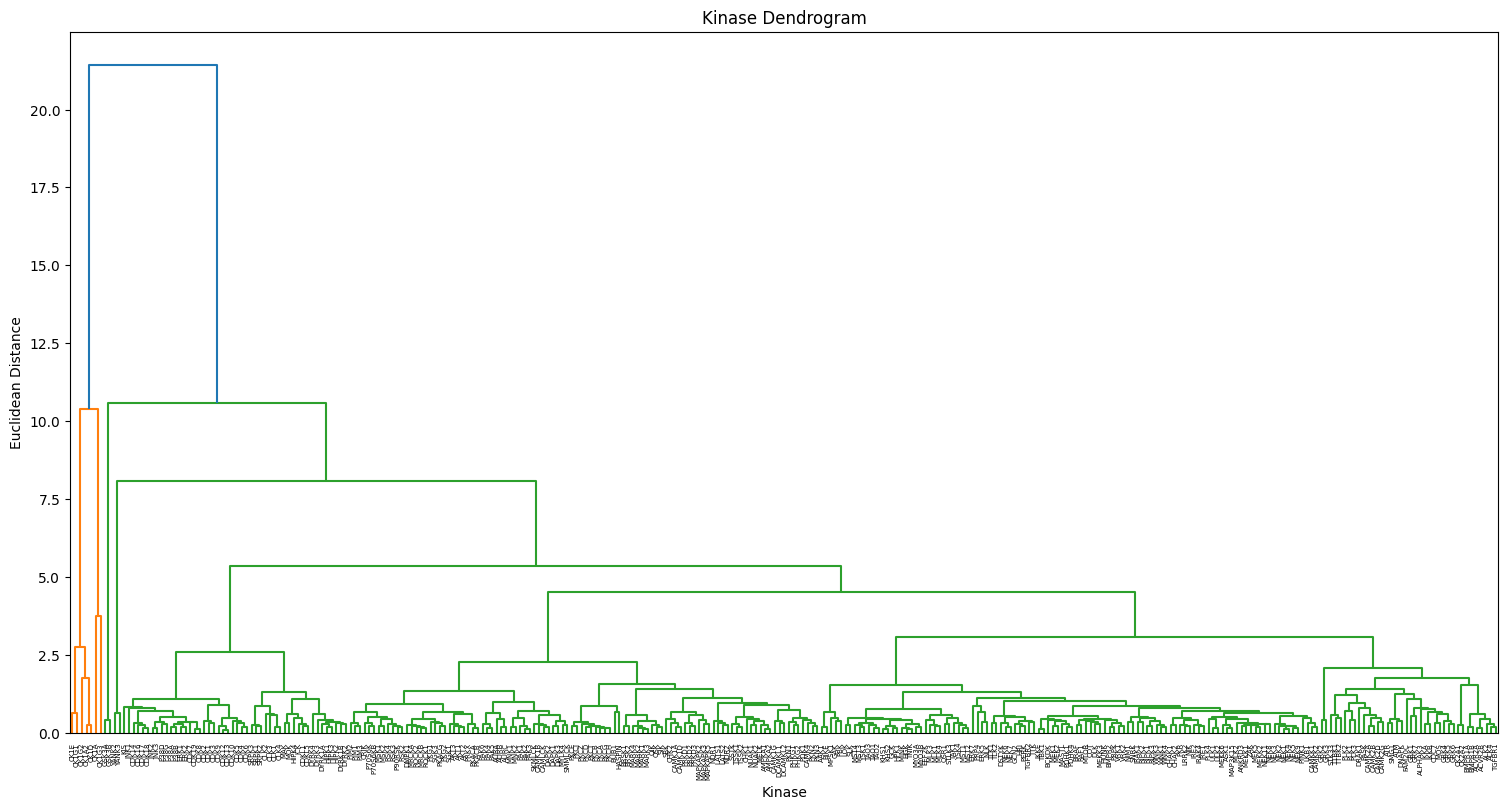

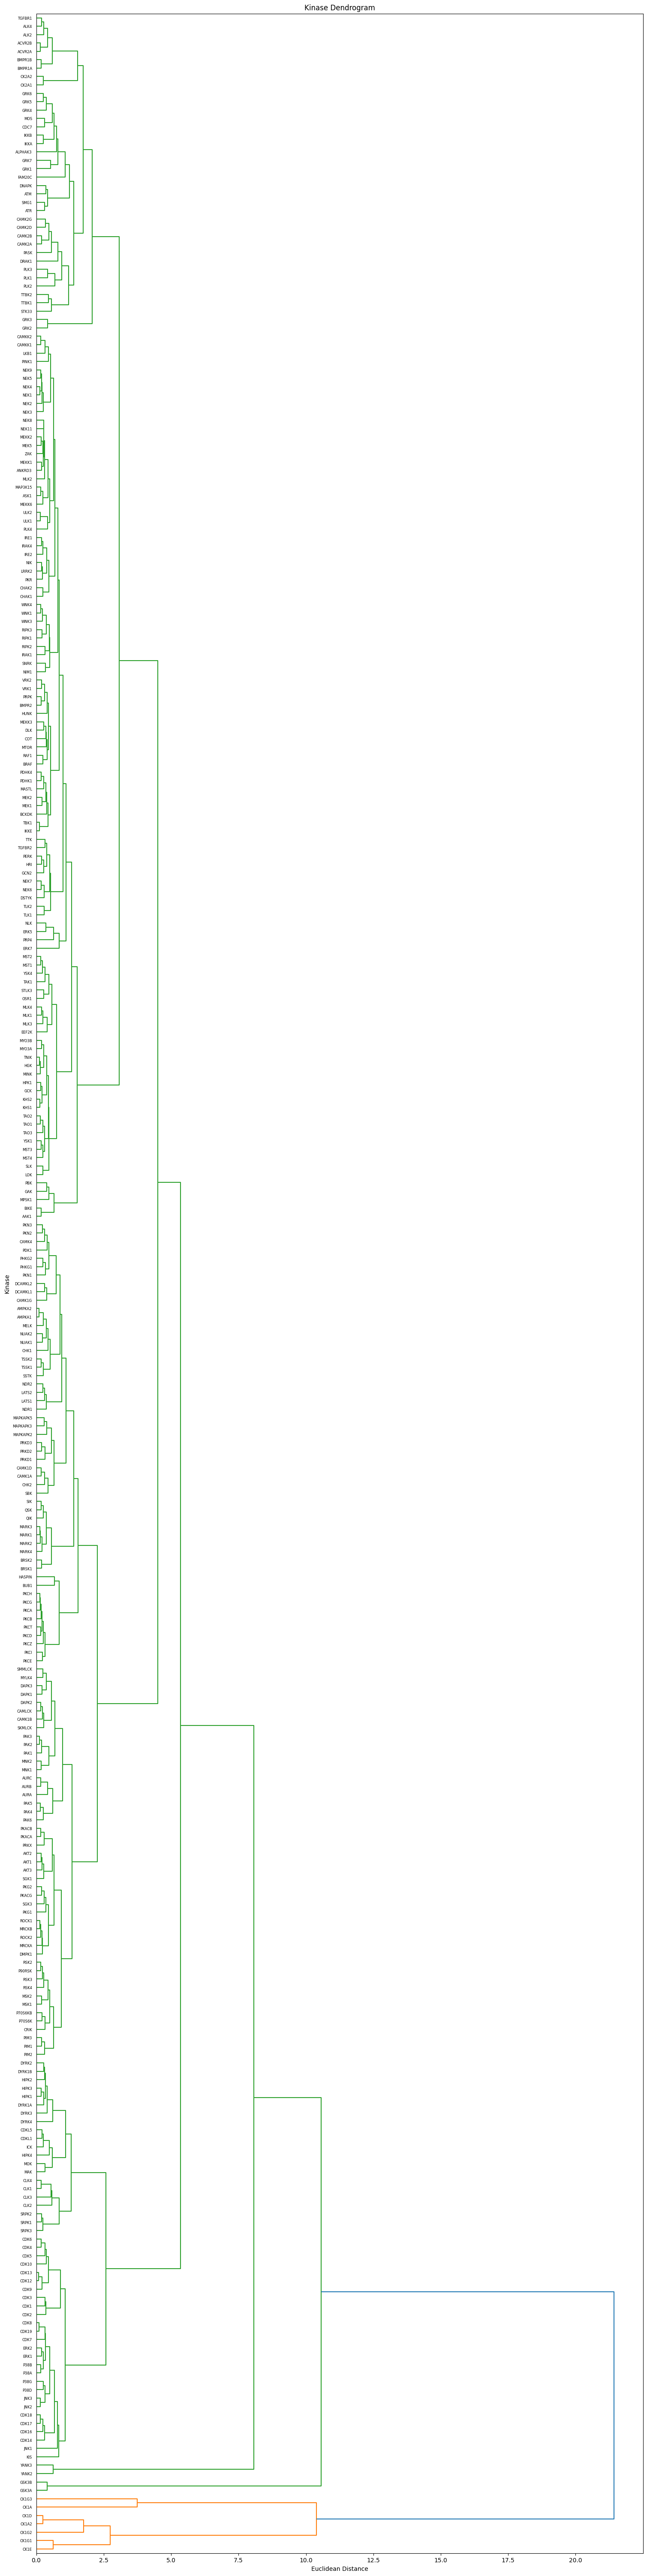

In [9]:
import pandas as pd

ser_thr_matrice_path = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Phylogenetic Distances\ser_thr_all_norm_matrices.csv"
df = pd.read_csv(ser_thr_matrice_path, index_col=0)
print(df.shape)
print(df.head())

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

# Calculate pairwise distances (Euclidean)
distances = pdist(df.values, metric='euclidean')

# Generate linkage matrix using Ward’s method (as in the paper)
linkage_matrix = linkage(distances, method='ward')

# Optional: visualize dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, labels=df.index.tolist(), leaf_rotation=90)
plt.title("Kinase Dendrogram")
plt.tight_layout()
plt.ylabel("Euclidean Distance")
plt.xlabel("Kinase")
plt.show()
plt.figure(figsize=(15, 60))
dendrogram(
    linkage_matrix,
    labels=df.index.tolist(),
    orientation='right',     # horizontal dendrogram
    leaf_font_size=6
)
plt.title("Kinase Dendrogram")
plt.tight_layout()
plt.xlabel("Euclidean Distance")
plt.ylabel("Kinase")
plt.show()


C:\Users\ricea\AppData\Local\Temp\ipykernel_22460\1713923121.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_distances, x='Type', y='Distance', palette='Set2')


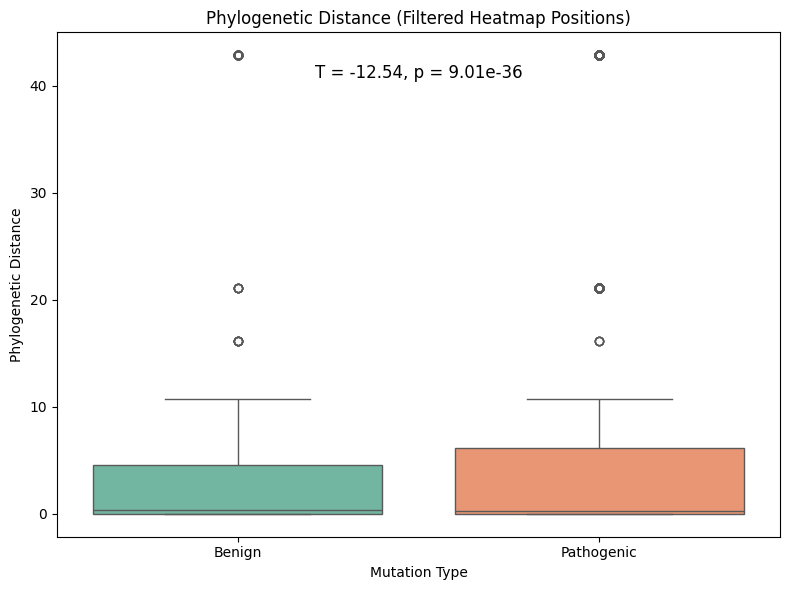

In [10]:
import os
import pandas as pd
from Bio import Phylo
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

# Load the phylogenetic tree
tree = Phylo.read("kinase_tree.nwk", "newick")

# Directories
benign_dir = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\benign_mutations2\mutations2"
pathogenic_dir = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\pathogenic_mutations2\mutations2"

# Helper function to extract top kinase
def get_top_kinase(file_path):
    try:
        df = pd.read_csv(file_path)
        return df.sort_values("Score", ascending=False).iloc[0]["index"]
    except Exception:
        return None

# Master list
records = []

for label, folder in [("Benign", benign_dir), ("Pathogenic", pathogenic_dir)]:
    for file in os.listdir(folder):
        if not file.endswith(".csv"):
            continue

        parts = file.split("_")
        if len(parts) < 4:
            continue

        uniprot, pos, kind = parts[0], parts[1], parts[2]

        # Extract position as integer
        try:
            heatmap_pos = int(file.split("pos")[1].split("_")[0])
        except:
            continue

        # Skip edge positions
        if heatmap_pos in [1, 2, 13, 14, 15]:
            continue

        # Build paths
        full_path = os.path.join(folder, file)
        wildtype_name = f"{uniprot}_{pos}_wildtype.csv"
        wildtype_path = os.path.join(folder, wildtype_name)

        # Ensure wildtype file exists
        if not os.path.exists(wildtype_path):
            continue

        # Get top kinases
        mutant_kinase = get_top_kinase(full_path)
        wildtype_kinase = get_top_kinase(wildtype_path)

        if mutant_kinase and wildtype_kinase:
            try:
                distance = tree.distance(mutant_kinase, wildtype_kinase)
                records.append({
                    "UniProt_ID": uniprot,
                    "Position": pos,
                    "Heatmap_Position": heatmap_pos,
                    "WT_Kinase": wildtype_kinase,
                    "Mut_Kinase": mutant_kinase,
                    "Distance": distance,
                    "Type": label
                })
            except:
                continue

# Save dataframe
df_distances = pd.DataFrame(records)
df_distances.to_csv("phylo_distances_filtered.csv", index=False)

# Run t-test
benign = df_distances[df_distances["Type"] == "Benign"]["Distance"]
pathogenic = df_distances[df_distances["Type"] == "Pathogenic"]["Distance"]
t_stat, p_val = ttest_ind(benign, pathogenic, equal_var=False)

# Plot boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_distances, x='Type', y='Distance', palette='Set2')
plt.title('Phylogenetic Distance (Filtered Heatmap Positions)')
plt.ylabel('Phylogenetic Distance')
plt.xlabel('Mutation Type')

# Annotate p and t
plt.text(0.5, df_distances['Distance'].max() * 0.95,
         f"T = {t_stat:.2f}, p = {p_val:.2e}",
         ha='center', fontsize=12)

plt.tight_layout()
plt.savefig("expanded_filtered_phylo_distance_boxplot.png", dpi=300)
plt.show()


Descriptive Statistics:
Benign - Mean: 2.9877, Median: 0.3320
Pathogenic - Mean: 5.0295, Median: 0.2916

Mann-Whitney U Test:
U-statistic = 10769772.00, p-value = 1.9358e-05


C:\Users\ricea\AppData\Local\Temp\ipykernel_22460\2188764372.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Type', y='Distance', palette='Set2')


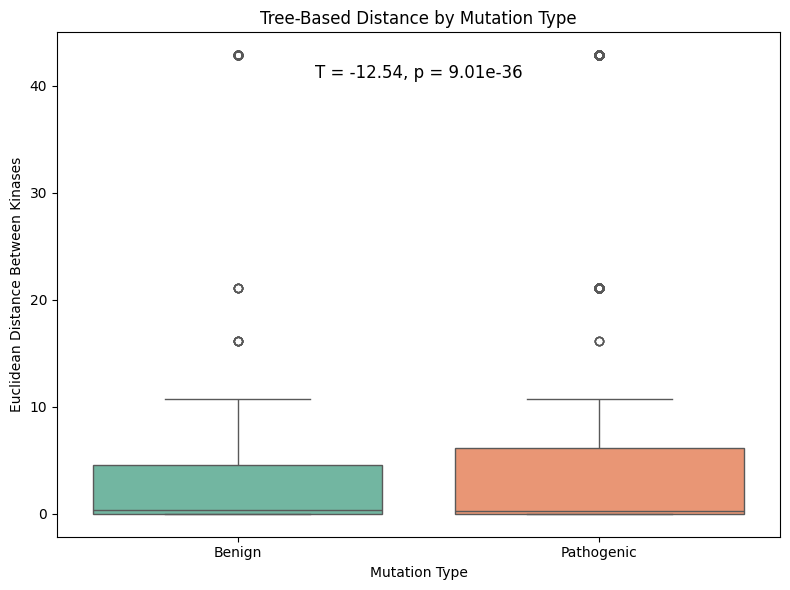

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import os

# Path to your CSV file
csv_path = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Phylogenetic Distances\phylo_distances_filtered.csv"
output_path = os.path.join(os.path.dirname(csv_path), "filtered_phylo_distance_boxplot.png")

# Load data
df = pd.read_csv(csv_path)

# T-test between groups
benign = df[df["Type"] == "Benign"]["Distance"]
pathogenic = df[df["Type"] == "Pathogenic"]["Distance"]

from scipy.stats import mannwhitneyu

# Calculate descriptive statistics
benign_mean = benign.mean()
benign_median = benign.median()
pathogenic_mean = pathogenic.mean()
pathogenic_median = pathogenic.median()

print("Descriptive Statistics:")
print(f"Benign - Mean: {benign_mean:.4f}, Median: {benign_median:.4f}")
print(f"Pathogenic - Mean: {pathogenic_mean:.4f}, Median: {pathogenic_median:.4f}")

# Mann-Whitney U Test (non-parametric)
u_stat, mw_p_val = mannwhitneyu(benign, pathogenic, alternative='two-sided')

print("\nMann-Whitney U Test:")
print(f"U-statistic = {u_stat:.2f}, p-value = {mw_p_val:.4e}")

t_stat, p_val = ttest_ind(benign, pathogenic, equal_var=False)

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Type', y='Distance', palette='Set2')
plt.title('Tree-Based Distance by Mutation Type')
plt.ylabel('Euclidean Distance Between Kinases')
plt.xlabel('Mutation Type')

# Annotate with stats
plt.text(0.5, df["Distance"].max() * 0.95,
         f"T = {t_stat:.2f}, p = {p_val:.2e}",
         ha='center', fontsize=12)

plt.tight_layout()
plt.savefig(output_path, dpi=300)
plt.show()


In [14]:
# Sample sizes
benign_n = len(benign)
pathogenic_n = len(pathogenic)

print(f"Sample Sizes:")
print(f"Benign: {benign_n}")
print(f"Pathogenic: {pathogenic_n}")


Sample Sizes:
Benign: 4438
Pathogenic: 5095
